In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

## a standard Logistic regression
https://laurentperrinet.github.io/sciblog/posts/2021-12-12-logistic-regression.html

### generative model for the data

In [2]:
N_input = 256 # dimension of X_input
n_classes = 10 # number of classes
N_batch = 4
seed = 1973 # release year of https://en.wikipedia.org/wiki/Ring_Ring_(ABBA_song)

np.random.seed(seed)
W = np.random.randn(N_input+1, n_classes) # FIXED design matrix

def psychometric_function(W, X_input):
    # print(W.shape, X_input.shape)
    logit = (X_input @ W[:-1, :]) + W[-1, :]
    return 1 / (1 + np.exp(-logit))

def get_data(W, seed, N_batch):
    N_input, n_classes = W.shape[0]-1, W.shape[1]
    np.random.seed(seed)
    X_input = np.random.randn(N_batch, N_input)
    p = psychometric_function(W, X_input)
    y = p > np.random.rand(N_batch, n_classes)  # generate data
    return X_input, p, y

X_input, p, y = get_data(W, seed, N_batch)
X_input.shape, y.shape

((4, 256), (4, 10))

In [3]:
y.shape, N_batch

((4, 10), 4)

### inference model

In [4]:
import torch

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = 'cpu'

device = 'cpu'

In [5]:
device

'cpu'

In [6]:
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
# see https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html#pytorch-loss-input-confusion-cheatsheet
criterion = torch.nn.BCELoss(reduction="mean") # loss divided by output size
#criterion = torch.nn.NLLLoss(reduction="mean") # loss divided by output size

class LogisticRegressionModel(torch.nn.Module):
    #torch.nn.Module -> Base class for all neural network modules
    def __init__(self, N, n_classes, logit0=torch.log(1.*torch.ones(1)), logit_wt=torch.log(0.1*torch.ones(1))):
        super(LogisticRegressionModel, self).__init__() 
        # self.linear = torch.nn.Linear(N, n_classes, bias=bias)

        self.bias = torch.nn.Parameter(logit0 * torch.ones(1, n_classes))
        self.weight = torch.nn.Parameter(logit_wt * torch.ones((N_input, n_classes)))
        # self.nl = torch.nn.LogSoftmax(n_classes)
        self.nl = torch.nn.Sigmoid()

    def forward(self, X_input):
        # X_input.shape = N_batch, N_input
        return self.nl(X_input @ self.weight +  self.bias)
        # return self.nl(self.linear(X_input))

/opt/homebrew/lib/python3.11/site-packages/torch/__init__.py:615: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [7]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1
batch_size = 256
n_classes = 10
amsgrad = False # gives similar results
amsgrad = True  # gives similar results

def fit_data(X_input, y, 
            learning_rate=learning_rate,
            batch_size=batch_size,  # gamma=gamma,
            num_epochs=num_epochs,
            betas=betas,
            verbose=False, **kwargs
        ):

    X, labels = torch.Tensor(X_input[:, None]), torch.Tensor(y[:, None])
    X, labels = X.to(device), labels.to(device)
    loader = DataLoader(
        TensorDataset(X, labels), batch_size=batch_size, shuffle=True
    )

    N_batch = X_input.shape[0]
    N = X_input.shape[1]
    n_classes = y.shape[1]
    logistic_model = LogisticRegressionModel(N, n_classes)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for X_, labels_ in loader:
            # X_, labels_ = X_.to(device), labels_.to(device)
            outputs = logistic_model(X_)
            loss = criterion(outputs, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    logistic_model.eval()
    X, labels = torch.Tensor(X_input[:, None]), torch.Tensor(y[:, None])
    outputs = logistic_model(X)
    loss = criterion(outputs, labels).item()
    return logistic_model, loss


X_input, p, y = get_data(W, seed=seed, N_batch=10000)
logistic_model, loss = fit_data(X_input, y, verbose=True)
print("Final loss =", loss)

Iteration: 0 - Loss: 18.72307
Iteration: 16 - Loss: 6.87101
Iteration: 32 - Loss: 0.73871
Iteration: 48 - Loss: 0.10731
Iteration: 64 - Loss: 0.06985
Iteration: 80 - Loss: 0.06688
Iteration: 96 - Loss: 0.06618
Iteration: 112 - Loss: 0.06635
Iteration: 128 - Loss: 0.06623
Iteration: 144 - Loss: 0.06655
Iteration: 160 - Loss: 0.06649
Iteration: 176 - Loss: 0.06587
Iteration: 192 - Loss: 0.06599
Iteration: 208 - Loss: 0.06603
Iteration: 224 - Loss: 0.06695
Iteration: 240 - Loss: 0.06672
Iteration: 256 - Loss: 0.06821
Iteration: 272 - Loss: 0.06662
Iteration: 288 - Loss: 0.06645
Iteration: 304 - Loss: 0.06740
Iteration: 320 - Loss: 0.06608
Iteration: 336 - Loss: 0.06566
Iteration: 352 - Loss: 0.06573
Iteration: 368 - Loss: 0.06599
Iteration: 384 - Loss: 0.06653
Iteration: 400 - Loss: 0.06576
Iteration: 416 - Loss: 0.06618
Iteration: 432 - Loss: 0.06570
Iteration: 448 - Loss: 0.06665
Iteration: 464 - Loss: 0.06570
Iteration: 480 - Loss: 0.06691
Iteration: 496 - Loss: 0.06599
Iteration: 512 

Text(0, 0.5, 'true bias')

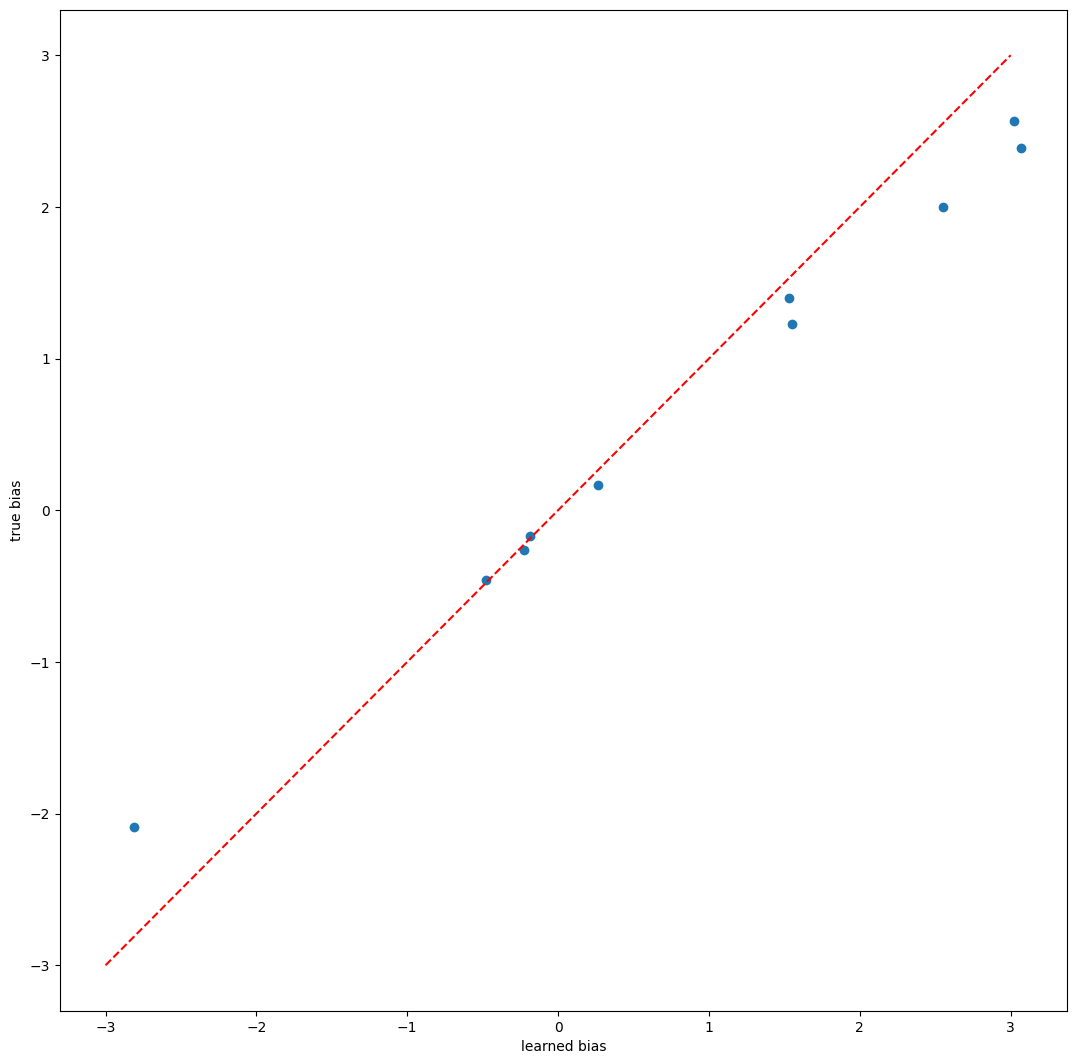

In [8]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.plot([-3, 3], [-3, 3], 'r--')
#ax.plot(logistic_model.linear.bias.detach().numpy(), 'r')
# ax.plot(W[-1, :], 'r--')
ax.scatter(logistic_model.bias.detach().numpy(), W[-1, :])
ax.set_xlabel('learned bias')
ax.set_ylabel('true bias')

In [9]:
logistic_model.weight.detach().numpy().shape, logistic_model.weight.detach().numpy().ravel().shape, W[:-1, :].shape, W[:-1, :].ravel().shape

((256, 10), (2560,), (256, 10), (2560,))

Text(0, 0.5, 'true factors')

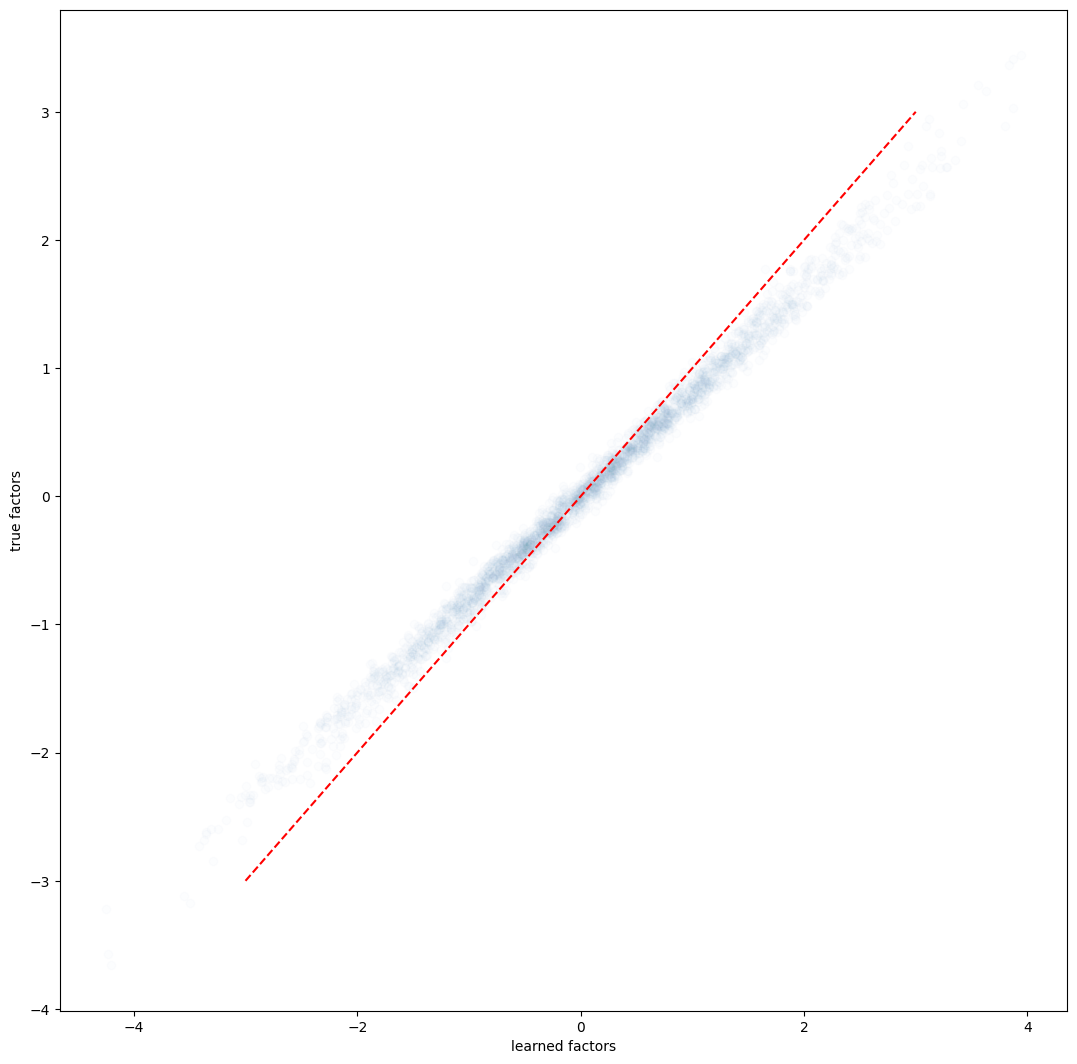

In [10]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.plot([-3, 3], [-3, 3], 'r--')
ax.scatter(logistic_model.weight.detach().numpy().ravel(), W[:-1, :].ravel(), alpha=.01)
ax.set_xlabel('learned factors')
ax.set_ylabel('true factors')

## Logistic regression with NaNs



### generative model for the data

In [11]:
N_input = 256 # number of X_input
n_classes = 10 # number of classes
N_batch = 4

p_NaN = .005 # percentage of NaNs

def get_data(W, seed, N_batch, p_NaN):
    N_input, n_classes = W.shape[0]-1, W.shape[1]
    np.random.seed(seed)
    X_input = np.random.randn(N_batch, N_input)
    p = psychometric_function(W, X_input)
    y = (p > np.random.rand(N_batch, n_classes))  # generate data
    X_input[np.random.rand(N_batch, N_input)<p_NaN] = np.NaN  # some parts of the data are not observable
    return X_input, p, y

X_input, p, y = get_data(W, seed, N_batch, p_NaN)
X_input.shape, y.shape

((4, 256), (4, 10))

In [12]:
X_input

array([[-1.80834952, -0.13619906, -0.80648188, ...,  0.434049  ,
         0.08255005, -0.78694834],
       [-0.37632552, -0.59738574,  1.11696778, ...,  0.81501842,
         0.21818331,         nan],
       [-0.37634137, -0.43356338,  0.44584921, ...,  0.60073607,
        -1.10058159,  0.013434  ],
       [-0.89518271,  1.0845264 , -0.57140918, ..., -0.33543602,
         0.2572201 , -0.52818111]])

In [13]:
np.isnan(X_input).sum(axis=1), np.isnan(p).sum(), np.isnan(y).sum()

(array([1, 2, 4, 1]), 0, 0)

In [14]:
p

array([[1.00000000e+00, 5.16416203e-01, 1.02413819e-01, 9.99840792e-01,
        9.77940787e-01, 9.43776930e-02, 5.06284936e-04, 8.99952836e-04,
        1.00000000e+00, 1.92779293e-05],
       [9.99999977e-01, 9.99998084e-01, 8.55022500e-09, 1.00000000e+00,
        9.99999970e-01, 2.36069802e-01, 9.64523357e-01, 1.10640081e-12,
        9.99999513e-01, 6.92597431e-05],
       [2.57852128e-02, 9.99996196e-01, 6.20986426e-02, 9.11545234e-01,
        6.48181739e-11, 9.99999999e-01, 1.02360082e-02, 9.99998219e-01,
        9.99999977e-01, 1.41057295e-05],
       [1.00000000e+00, 9.99999983e-01, 3.76846841e-04, 2.33812629e-04,
        9.99889176e-01, 5.37469629e-01, 7.33585772e-08, 1.01885133e-07,
        9.99999694e-01, 4.01410283e-03]])

In [15]:
y

array([[ True,  True, False,  True,  True, False, False, False,  True,
        False],
       [ True,  True, False,  True,  True,  True,  True, False,  True,
        False],
       [False,  True, False,  True, False,  True, False,  True,  True,
        False],
       [ True,  True, False, False,  True, False, False, False,  True,
        False]])

### inference model

In [16]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
# see https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html#pytorch-loss-input-confusion-cheatsheet
criterion = torch.nn.BCELoss(reduction="mean") # loss divided by output size
#criterion = torch.nn.NLLLoss(reduction="mean") # loss divided by output size


class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, N, n_classes, logit0=torch.log(1.*torch.ones(1)), logit_wt=torch.log(0.1*torch.ones(1))):
        super(LogisticRegressionModel, self).__init__() 
        # self.linear = torch.nn.Linear(N, n_classes, bias=bias)

        self.bias = torch.nn.Parameter(logit0 * torch.ones(1, n_classes))
        self.weight = torch.nn.Parameter(logit_wt * torch.ones((N_input, n_classes)))
        # self.nl = torch.nn.LogSoftmax(n_classes)
        self.nl = torch.nn.Sigmoid()

    def forward(self, X_input):
        # X_input.shape = N_batch, N_input
        mask = torch.isnan(X_input)
        X_input[mask] = 0.
        return self.nl(X_input @ self.weight +  self.bias)
        
    

In [17]:
logistic_model = LogisticRegressionModel(N_input, n_classes)
X_input, p, y = get_data(W, seed, N_batch, p_NaN)
outputs = logistic_model(torch.tensor(X_input.astype(float)))
outputs

tensor([[2.8270e-11, 2.8270e-11, 2.8270e-11, 2.8270e-11, 2.8270e-11, 2.8270e-11,
         2.8270e-11, 2.8270e-11, 2.8270e-11, 2.8270e-11],
        [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00],
        [7.4381e-01, 7.4381e-01, 7.4381e-01, 7.4381e-01, 7.4381e-01, 7.4381e-01,
         7.4381e-01, 7.4381e-01, 7.4381e-01, 7.4381e-01],
        [7.4768e-42, 7.4768e-42, 7.4768e-42, 7.4768e-42, 7.4768e-42, 7.4768e-42,
         7.4768e-42, 7.4768e-42, 7.4768e-42, 7.4768e-42]],
       grad_fn=<SigmoidBackward0>)

In [18]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1
batch_size = 256
n_classes=10
amsgrad = True  # gives similar results
amsgrad = False # gives similar results

def fit_data(X_input, y, 
            learning_rate=learning_rate,
            batch_size=batch_size,  # gamma=gamma,
            num_epochs=num_epochs,
            betas=betas,
            verbose=False, **kwargs
        ):

    X, labels = torch.Tensor(X_input[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(X, labels), batch_size=batch_size, shuffle=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    N_batch = X_input.shape[0]
    N = X_input.shape[1]
    n_classes = y.shape[1]
    logistic_model = LogisticRegressionModel(N, n_classes)
    # logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for X_, labels_ in loader:
            # X_, labels_ = X_.to(device), labels_.to(device)
            outputs = logistic_model(X_)
            loss = criterion(outputs, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    logistic_model.eval()
    X, labels = torch.Tensor(X_input[:, None]), torch.Tensor(y[:, None])
    outputs = logistic_model(X)
    loss = criterion(outputs, labels).item()
    return logistic_model, loss


X_input, p, y = get_data(W, seed=seed, N_batch=100000, p_NaN=p_NaN)
logistic_model, loss = fit_data(X_input, y, verbose=True)
print("Final loss =", loss)

Iteration: 0 - Loss: 14.81964
Iteration: 16 - Loss: 0.09919
Iteration: 32 - Loss: 0.09770
Iteration: 48 - Loss: 0.09743
Iteration: 64 - Loss: 0.09731
Iteration: 80 - Loss: 0.09733
Iteration: 96 - Loss: 0.09737
Iteration: 112 - Loss: 0.09732
Iteration: 128 - Loss: 0.09733
Iteration: 144 - Loss: 0.09737
Iteration: 160 - Loss: 0.09730
Iteration: 176 - Loss: 0.09732
Iteration: 192 - Loss: 0.09733
Iteration: 208 - Loss: 0.09745
Iteration: 224 - Loss: 0.09733
Iteration: 240 - Loss: 0.09732
Iteration: 256 - Loss: 0.09734
Iteration: 272 - Loss: 0.09733
Iteration: 288 - Loss: 0.09740
Iteration: 304 - Loss: 0.09730
Iteration: 320 - Loss: 0.09742
Iteration: 336 - Loss: 0.09738
Iteration: 352 - Loss: 0.09738
Iteration: 368 - Loss: 0.09732
Iteration: 384 - Loss: 0.09736
Iteration: 400 - Loss: 0.09735
Iteration: 416 - Loss: 0.09736
Iteration: 432 - Loss: 0.09734
Iteration: 448 - Loss: 0.09736
Iteration: 464 - Loss: 0.09729
Iteration: 480 - Loss: 0.09734
Iteration: 496 - Loss: 0.09738
Iteration: 512 

Text(0, 0.5, 'X_input')

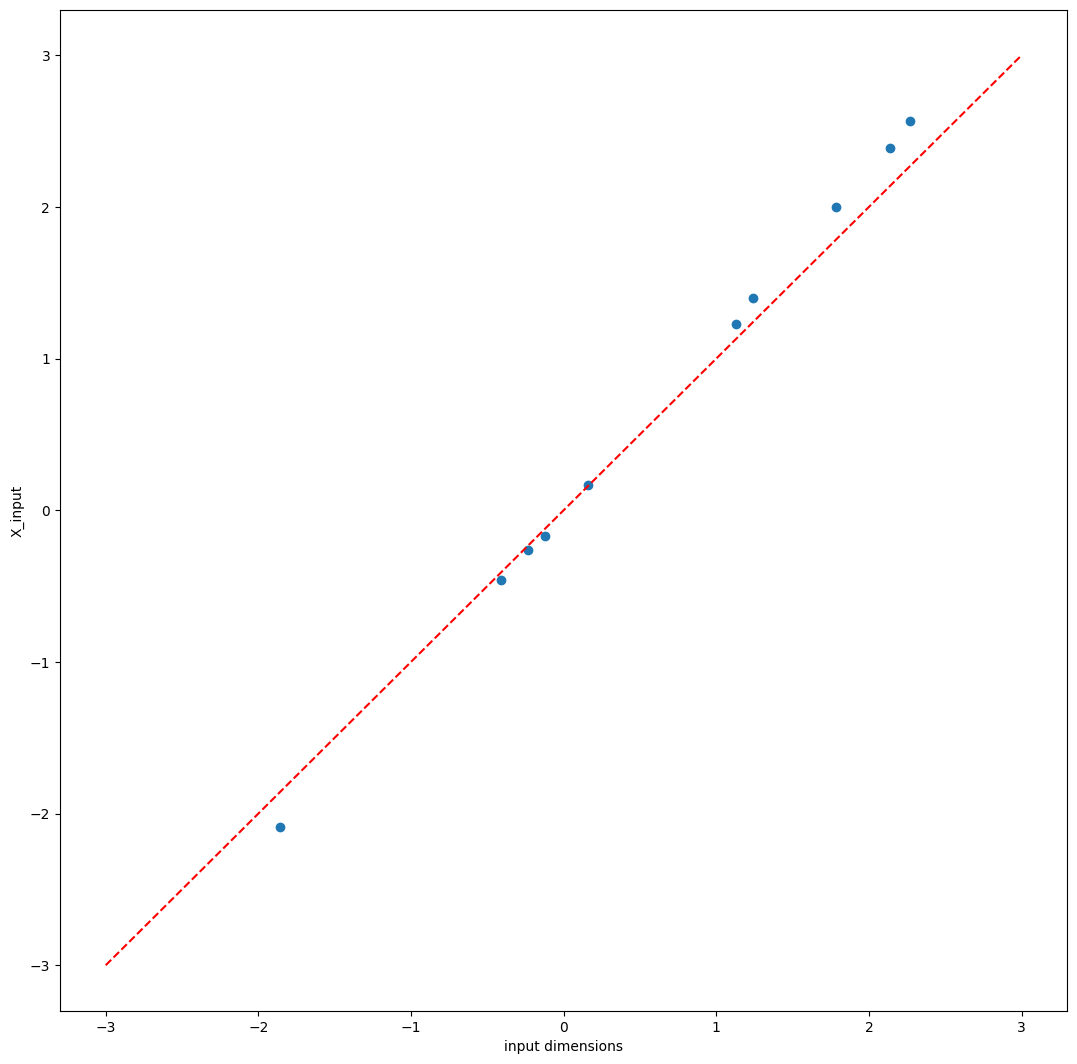

In [19]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.plot([-3, 3], [-3, 3], 'r--')
#ax.plot(logistic_model.linear.bias.detach().numpy(), 'r')
# ax.plot(W[-1, :], 'r--')
ax.scatter(logistic_model.bias.detach().numpy(), W[-1, :])
ax.set_xlabel('input dimensions')
ax.set_ylabel('X_input')

In [20]:
logistic_model.linear.weight.detach().numpy().shape, logistic_model.linear.weight.detach().numpy().ravel().shape, W[:-1, :].shape, W[:-1, :].ravel().shape

AttributeError: 'LogisticRegressionModel' object has no attribute 'linear'

In [ ]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.plot([-3, 3], [-3, 3], 'r--')
ax.scatter(logistic_model.weight.detach().numpy().ravel(), W[:-1, :].ravel(), alpha=.01)
ax.set_xlabel('input dimensions')
ax.set_ylabel('X_input')